In [1]:
import torch
import itertools
import pickle
import os
import random
from model import GPTConfig, GPT

# Charger les informations d'encodage depuis meta.pkl
with open('data/txt/meta.pkl', 'rb') as f:
    meta = pickle.load(f)
stoi, itos = meta['stoi'], meta['itos']

# Fonction d'encodage
def encode(s):
    return [stoi[c] for c in s if c in stoi]

# Fonction de décodage (pour la vérification si nécessaire)
def decode(l):
    return ''.join([itos[i] for i in l])

# Fonction pour encoder un jeu
def encode_game(game):
    return encode(' '.join(move for move in game))

# Génération de parties aléatoires
def generate_random_games(num_games=5000):
    all_games = []
    positions = list(itertools.product(range(3), repeat=2))
    
    def backtrack(board, moves):
        if len(moves) == 9 or any(row.count(player) == 3 for row in board + list(map(list, zip(*board))) for player in ['X', 'O']):
            all_games.append(moves)
            return
        player = 'X' if len(moves) % 2 == 0 else 'O'
        available_positions = [pos for pos in positions if board[pos[0]][pos[1]] == ' ']
        if not available_positions:
            all_games.append(moves)
            return
        pos = random.choice(available_positions)
        i, j = pos
        new_board = [row[:] for row in board]
        new_board[i][j] = player
        new_moves = moves + [f"{player}{i+1}{j+1}"]
        backtrack(new_board, new_moves)
    
    while len(all_games) < num_games:
        initial_board = [[' ' for _ in range(3)] for _ in range(3)]
        backtrack(initial_board, [])
    
    return random.sample(all_games, num_games)

out_dir = 'out-txt-models/'
device = 'cpu'

# Charger le modèle
ckpt_path = os.path.join(out_dir, 'ckpt_iter_3200.pt')
checkpoint = torch.load(ckpt_path, map_location=device)
gptconf = GPTConfig(**checkpoint['model_args'])
model = GPT(gptconf)

# Modifier les clés du state_dict si nécessaire
state_dict = checkpoint['model']
new_state_dict = {}
for k, v in state_dict.items():
    name = k.replace("_orig_mod.", "") # supprimer le préfixe "_orig_mod." si présent
    new_state_dict[name] = v

# Charger le state_dict modifié
model.load_state_dict(new_state_dict)
model.eval()

# Fonction pour extraire les activations
activations = []
def hook_fn(module, input, output):
    activations.append(output.detach())

# Ajouter le hook à la dernière couche MLP
last_mlp = model.transformer.h[-1].mlp
last_mlp.register_forward_hook(hook_fn)

# Générer 5000 parties aléatoires
random_games = generate_random_games(2000)

# Générer les activations pour chaque caractère de chaque partie
all_activations = []
for game in random_games:
    encoded_game = encode_game(game)
    for i in range(len(encoded_game)):
        input_ids = torch.tensor(encoded_game[:i+1], dtype=torch.long, device=device).unsqueeze(0)
        with torch.no_grad():
            model(input_ids)
        # Assurez-vous que l'activation a toujours 2 dimensions
        activation = activations[-1].squeeze()
        if activation.dim() == 1:
            activation = activation.unsqueeze(0)
        all_activations.append(activation)
    activations.clear()

# Trouver la longueur maximale
max_len = max(tensor.size(0) for tensor in all_activations)

# Padding des tenseurs pour qu'ils aient tous la même taille
padded_activations = []
for tensor in all_activations:
    if tensor.size(0) < max_len:
        padding = torch.zeros(max_len - tensor.size(0), tensor.size(1), device=device)
        padded_tensor = torch.cat([tensor, padding], dim=0)
    else:
        padded_tensor = tensor
    padded_activations.append(padded_tensor)

# Convertir en tensor
all_activations = torch.stack(padded_activations)
print(f"Shape of all_activations: {all_activations.shape}")

/var/folders/gr/7v3jlz_j0dx2j8p9lhps4rm00000gn/T/ipykernel_2678/321537359.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_locatio

number of parameters: 1.58M
Shape of all_activations: torch.Size([61764, 35, 256])


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

# Détection du device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, sparsity_target=0.05, sparsity_weight=0.1, l1_weight=1e-5, l2_weight=1e-5):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_dim)
        self.sparsity_target = sparsity_target
        self.sparsity_weight = sparsity_weight
        self.l1_weight = l1_weight
        self.l2_weight = l2_weight
        
        # Initialisation personnalisée
        nn.init.xavier_uniform_(self.encoder.weight)
        nn.init.xavier_uniform_(self.decoder.weight)
        nn.init.zeros_(self.encoder.bias)
        nn.init.zeros_(self.decoder.bias)

    def forward(self, x):
        encoded = torch.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return encoded, decoded

    def loss_function(self, x, decoded, encoded):
        # Perte de reconstruction
        reconstruction_loss = F.mse_loss(decoded, x)
        
        # Perte de sparsité (KL divergence)
        p_hat = torch.mean(encoded, dim=0)
        sparsity_loss = torch.sum(self.kl_divergence(self.sparsity_target, p_hat))
        
        # Régularisation L1
        l1_loss = sum(torch.sum(torch.abs(param)) for param in self.parameters())
        
        # Régularisation L2
        l2_loss = sum(torch.sum(param.pow(2)) for param in self.parameters())
        
        # Perte totale
        total_loss = reconstruction_loss + self.sparsity_weight * sparsity_loss + self.l1_weight * l1_loss + self.l2_weight * l2_loss
        
        return total_loss, {
            'reconstruction': reconstruction_loss.item(),
            'sparsity': sparsity_loss.item(),
            'l1': l1_loss.item(),
            'l2': l2_loss.item()
        }

    @staticmethod
    def kl_divergence(p, p_hat):
        epsilon = 1e-10
        p_hat = torch.clamp(p_hat, epsilon, 1 - epsilon)
        return p * torch.log(p / p_hat) + (1 - p) * torch.log((1 - p) / (1 - p_hat))

def check_nan(tensor, name):
    if torch.isnan(tensor).any():
        print(f"NaN detected in {name}")
        return True
    return False

# Exemple d'utilisation :
input_dim = all_activations.shape[2]  # À ajuster selon la dimension de vos données
encoding_dim = 1024
sparsity_target = 0.05
sparsity_weight = 0.0001  # Réduit de 0.1 à 0.0001
l1_weight = 1e-5  # Réduit de 1e-5 à 1e-6
l2_weight = 1e-6
num_epochs = 1000
batch_size = 1024

# Normalisation des données
mean = all_activations.mean()
std = all_activations.std()
all_activations = (all_activations - mean) / (std + 1e-10)

# Assurez-vous que all_activations est sur le bon device
all_activations = all_activations.to(device)

sae = SparseAutoencoder(input_dim, encoding_dim, sparsity_target, sparsity_weight, l1_weight, l2_weight).to(device)
optimizer = torch.optim.Adam(sae.parameters(), lr=1e-5)  # Taux d'apprentissage réduit à 1e-5
scaler = GradScaler()

# Boucle d'entraînement
for epoch in range(num_epochs):
    total_loss = 0
    for i in range(0, all_activations.shape[0], batch_size):
        batch = all_activations[i:i+batch_size]
        optimizer.zero_grad()
        
        with autocast():
            encoded, decoded = sae(batch)
            if check_nan(encoded, "encoded") or check_nan(decoded, "decoded"):
                continue
            loss, loss_components = sae.loss_function(batch, decoded, encoded)
            if check_nan(loss, "loss"):
                print(f"Reconstruction: {loss_components['reconstruction']:.4f}, "
                      f"Sparsity: {loss_components['sparsity']:.4f}, "
                      f"L1: {loss_components['l1']:.4f}, "
                      f"L2: {loss_components['l2']:.4f}")
                continue
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(sae.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Average Loss: {total_loss/all_activations.shape[0]:.4f}, '
              f'Reconstruction: {loss_components["reconstruction"]:.4f}, '
              f'Sparsity: {loss_components["sparsity"]:.4f}, '
              f'L1: {loss_components["l1"]:.4f}, '
              f'L2: {loss_components["l2"]:.4f}')

# Sauvegarder le modèle
torch.save(sae.state_dict(), 'sae_model.pth')

Using device: mps


/var/folders/gr/7v3jlz_j0dx2j8p9lhps4rm00000gn/T/ipykernel_2678/99045826.py:92: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/opt/homebrew/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/var/folders/gr/7v3jlz_j0dx2j8p9lhps4rm00000gn/T/ipykernel_2678/99045826.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/homebrew/lib/python3.12/site-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [5/1000], Average Loss: inf, Reconstruction: 0.3476, Sparsity: inf, L1: 17868.1758, L2: 814.5392
Epoch [10/1000], Average Loss: inf, Reconstruction: 0.1278, Sparsity: inf, L1: 17764.9551, L2: 809.4485
Epoch [15/1000], Average Loss: inf, Reconstruction: 0.0696, Sparsity: inf, L1: 17614.2461, L2: 802.0329
Epoch [20/1000], Average Loss: inf, Reconstruction: 0.0461, Sparsity: inf, L1: 17387.9746, L2: 790.4800
Epoch [25/1000], Average Loss: inf, Reconstruction: 0.0356, Sparsity: inf, L1: 17139.7383, L2: 777.4851
Epoch [30/1000], Average Loss: inf, Reconstruction: 0.0292, Sparsity: inf, L1: 16875.8203, L2: 763.6089
Epoch [35/1000], Average Loss: inf, Reconstruction: 0.0247, Sparsity: inf, L1: 16595.7324, L2: 748.9440
Epoch [40/1000], Average Loss: inf, Reconstruction: 0.0214, Sparsity: inf, L1: 16295.8281, L2: 733.3623
Epoch [45/1000], Average Loss: inf, Reconstruction: 0.0190, Sparsity: inf, L1: 15980.2803, L2: 717.2039
Epoch [50/1000], Average Loss: inf, Reconstruction: 0.0171, Spars

KeyboardInterrupt: 

Using device: mps


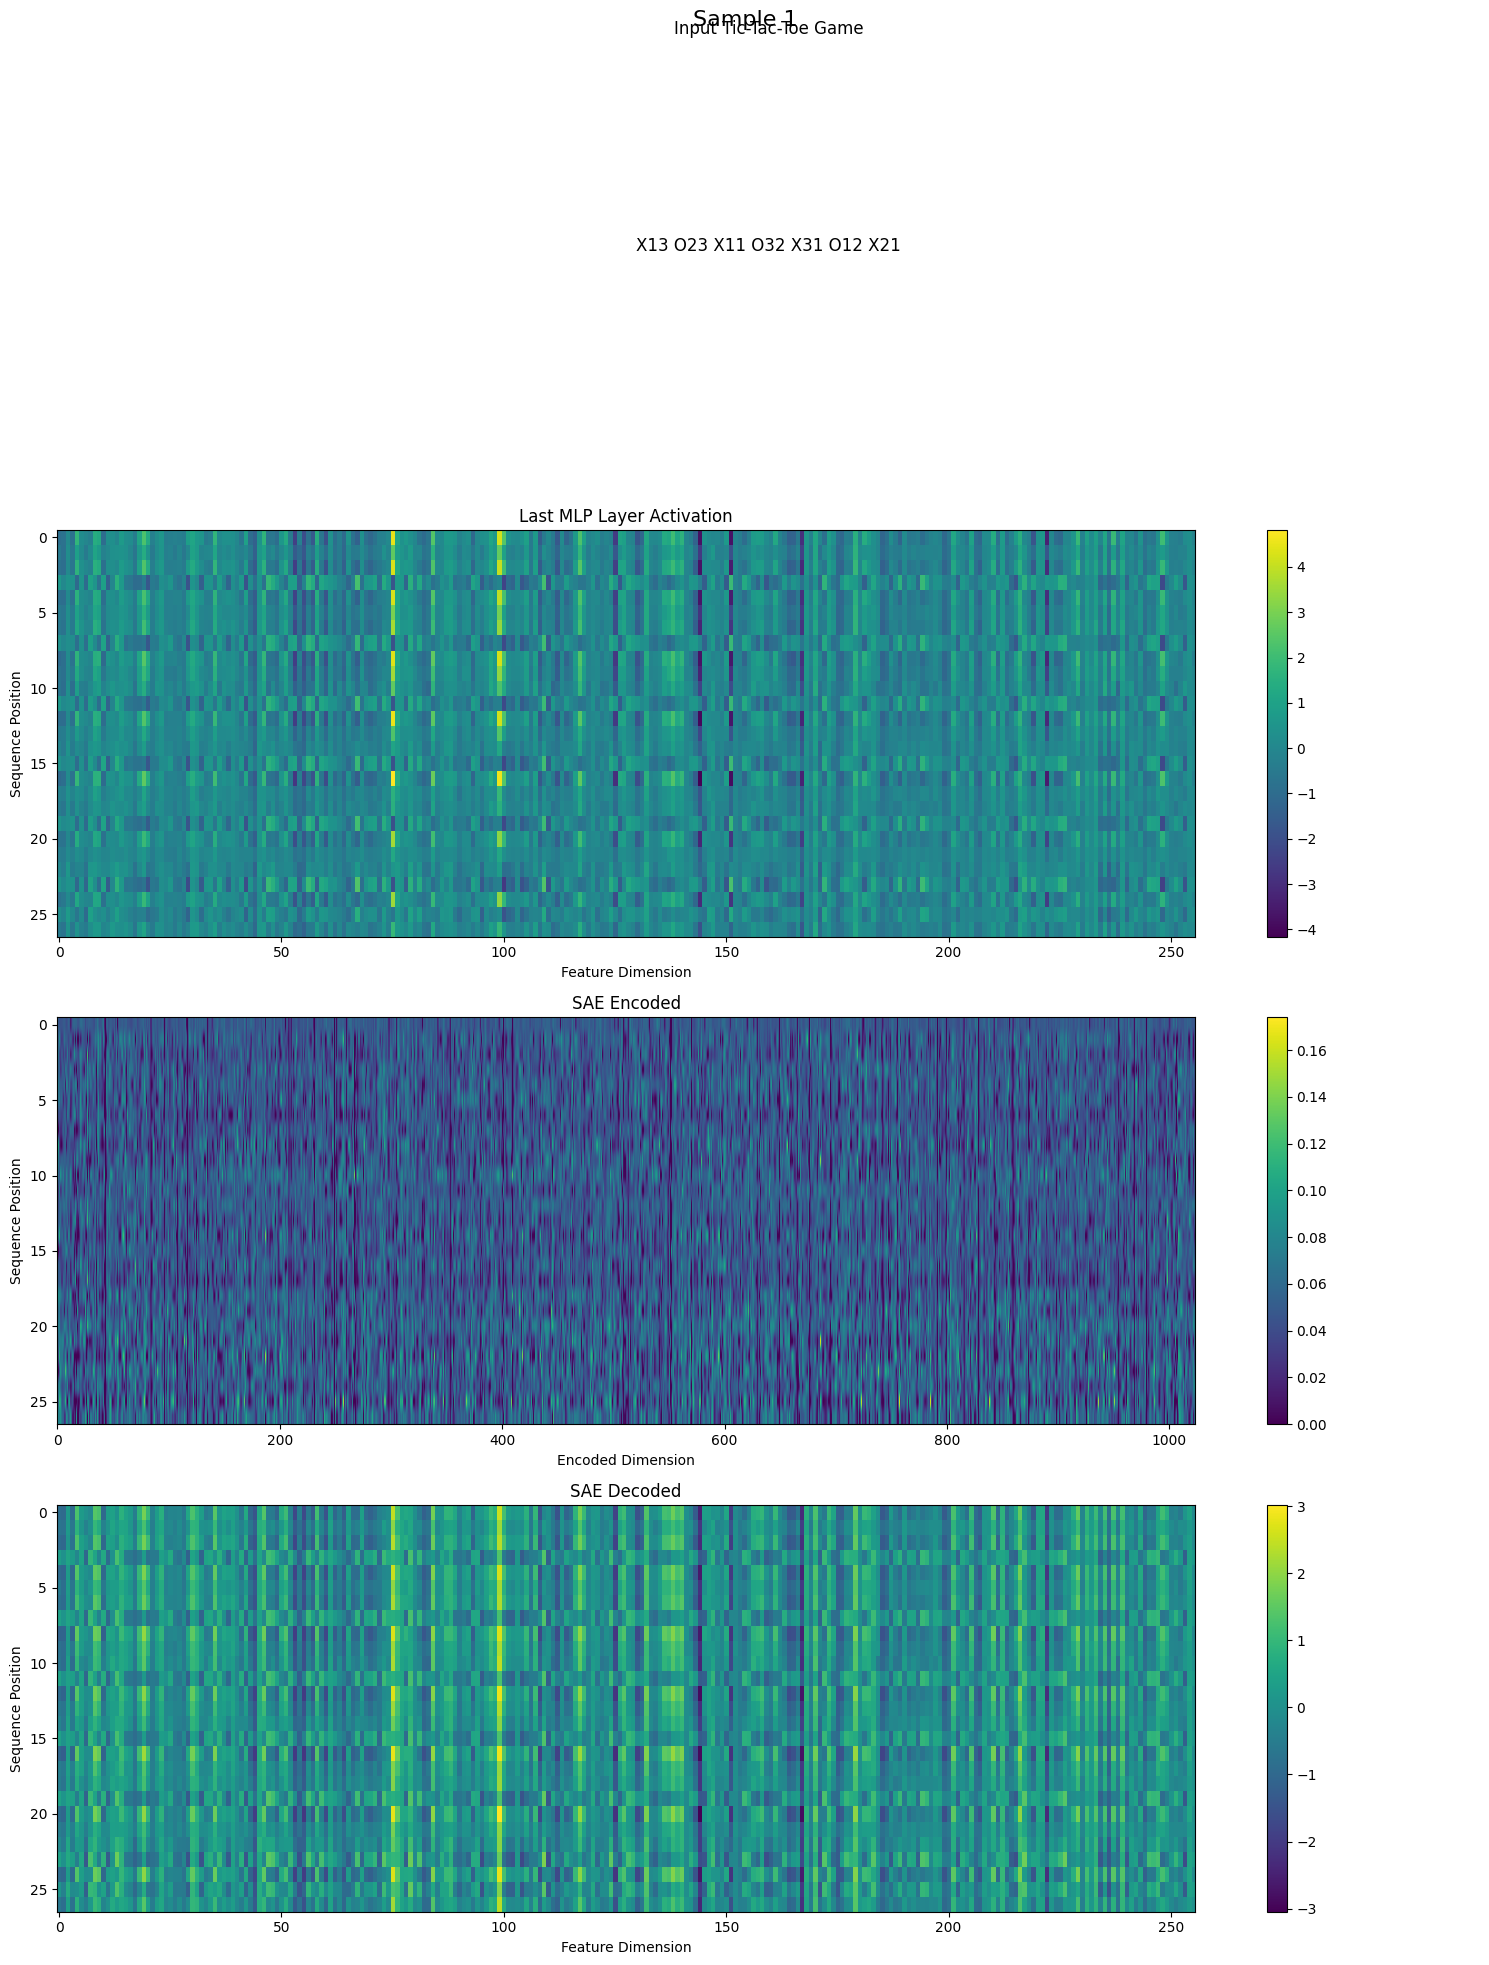

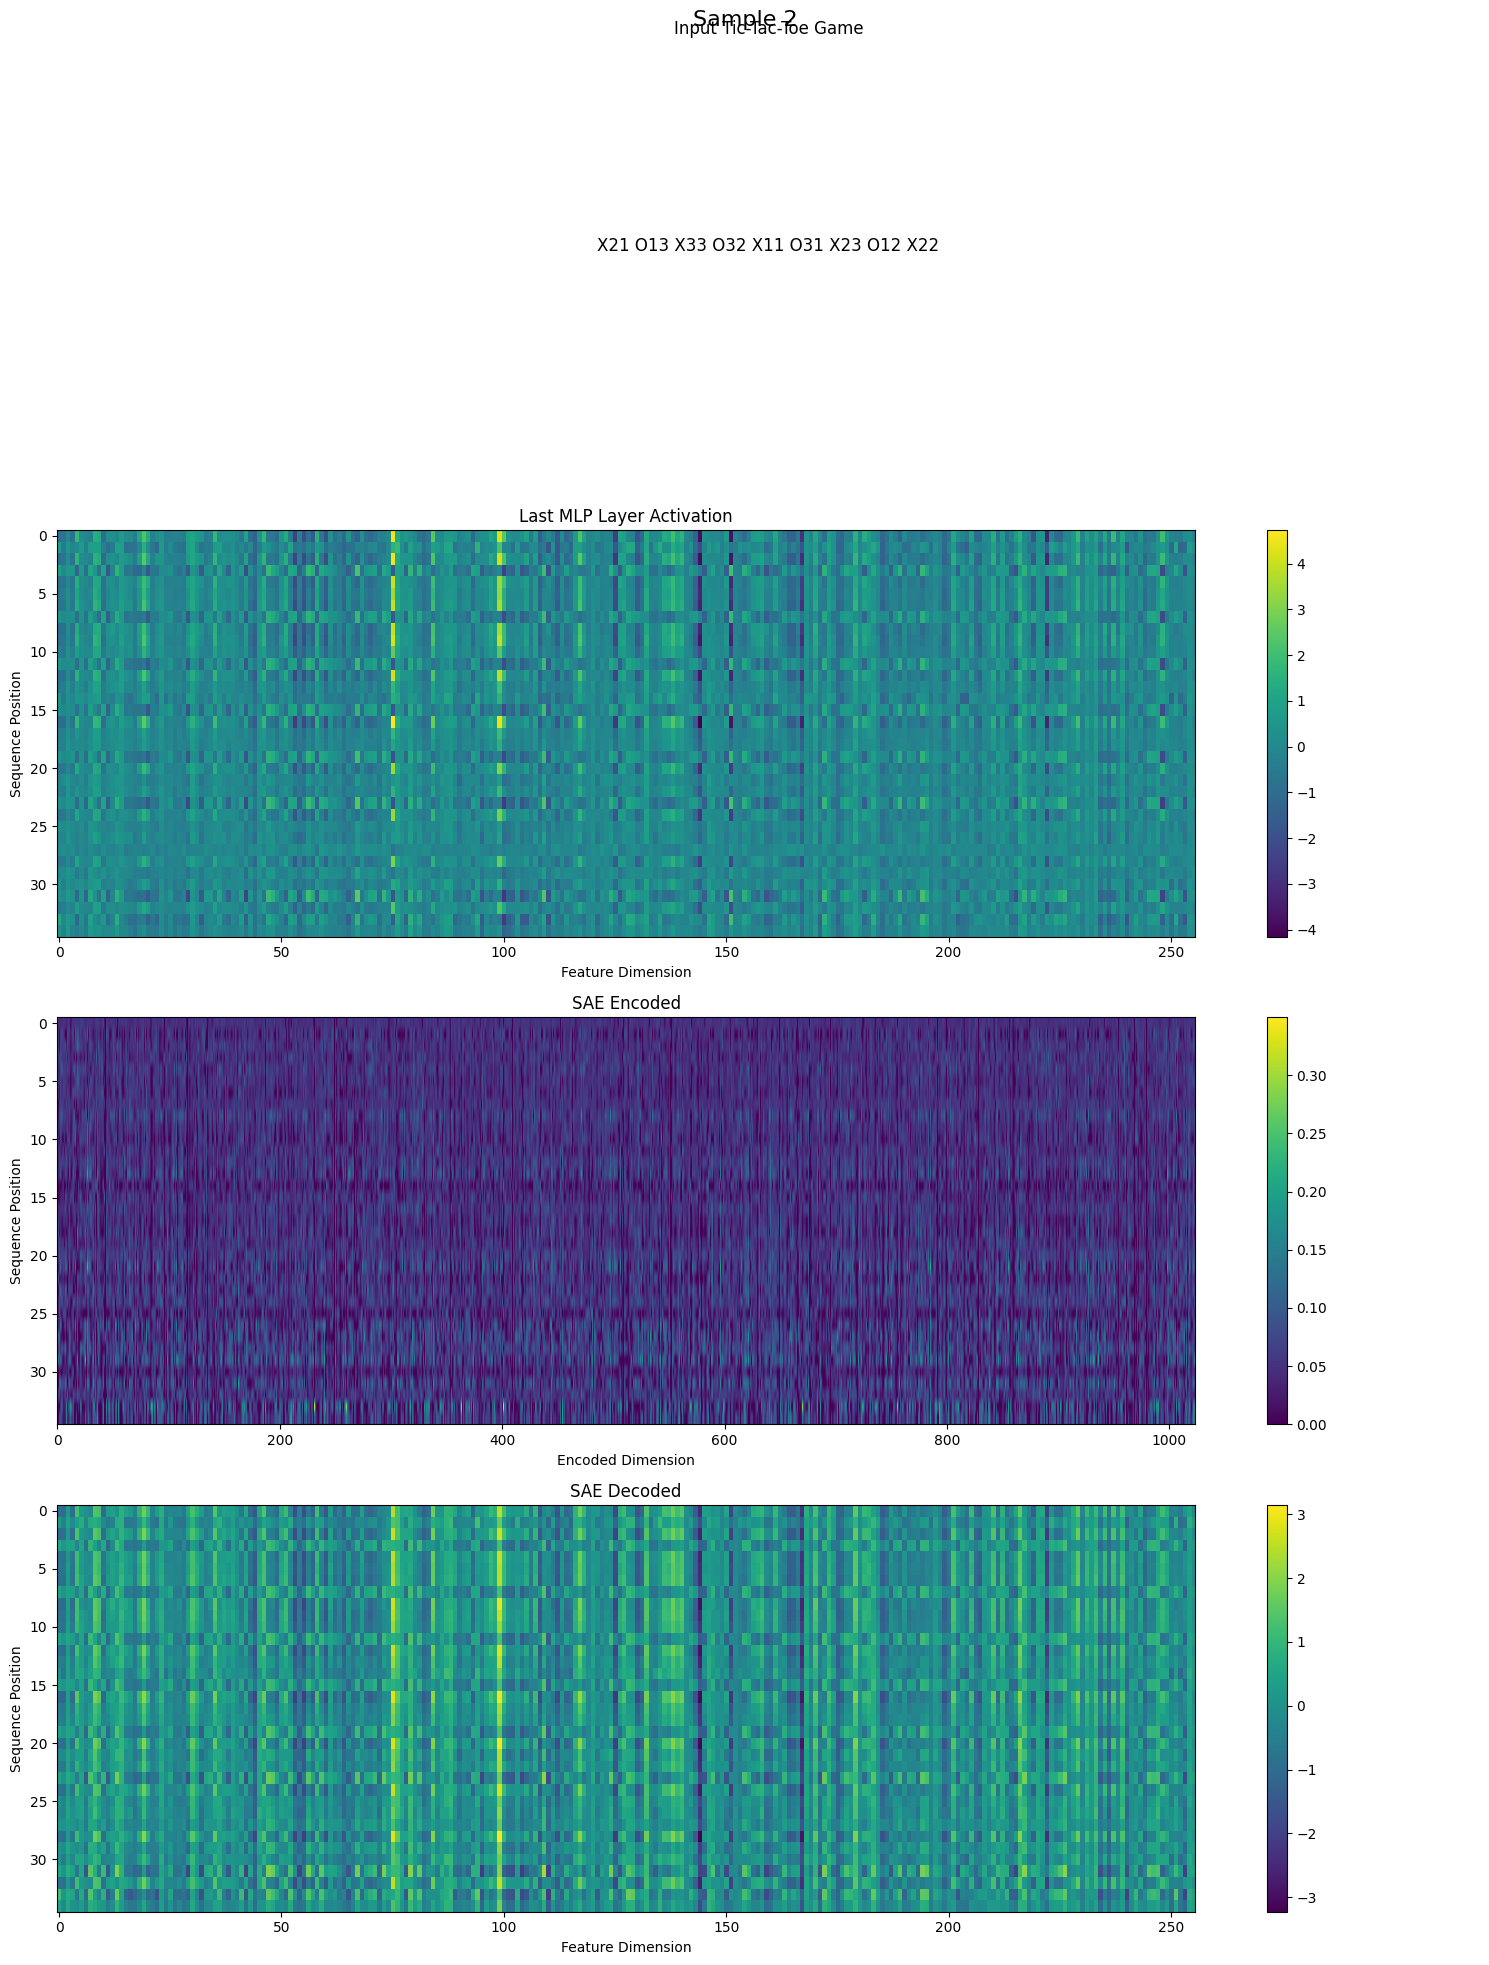

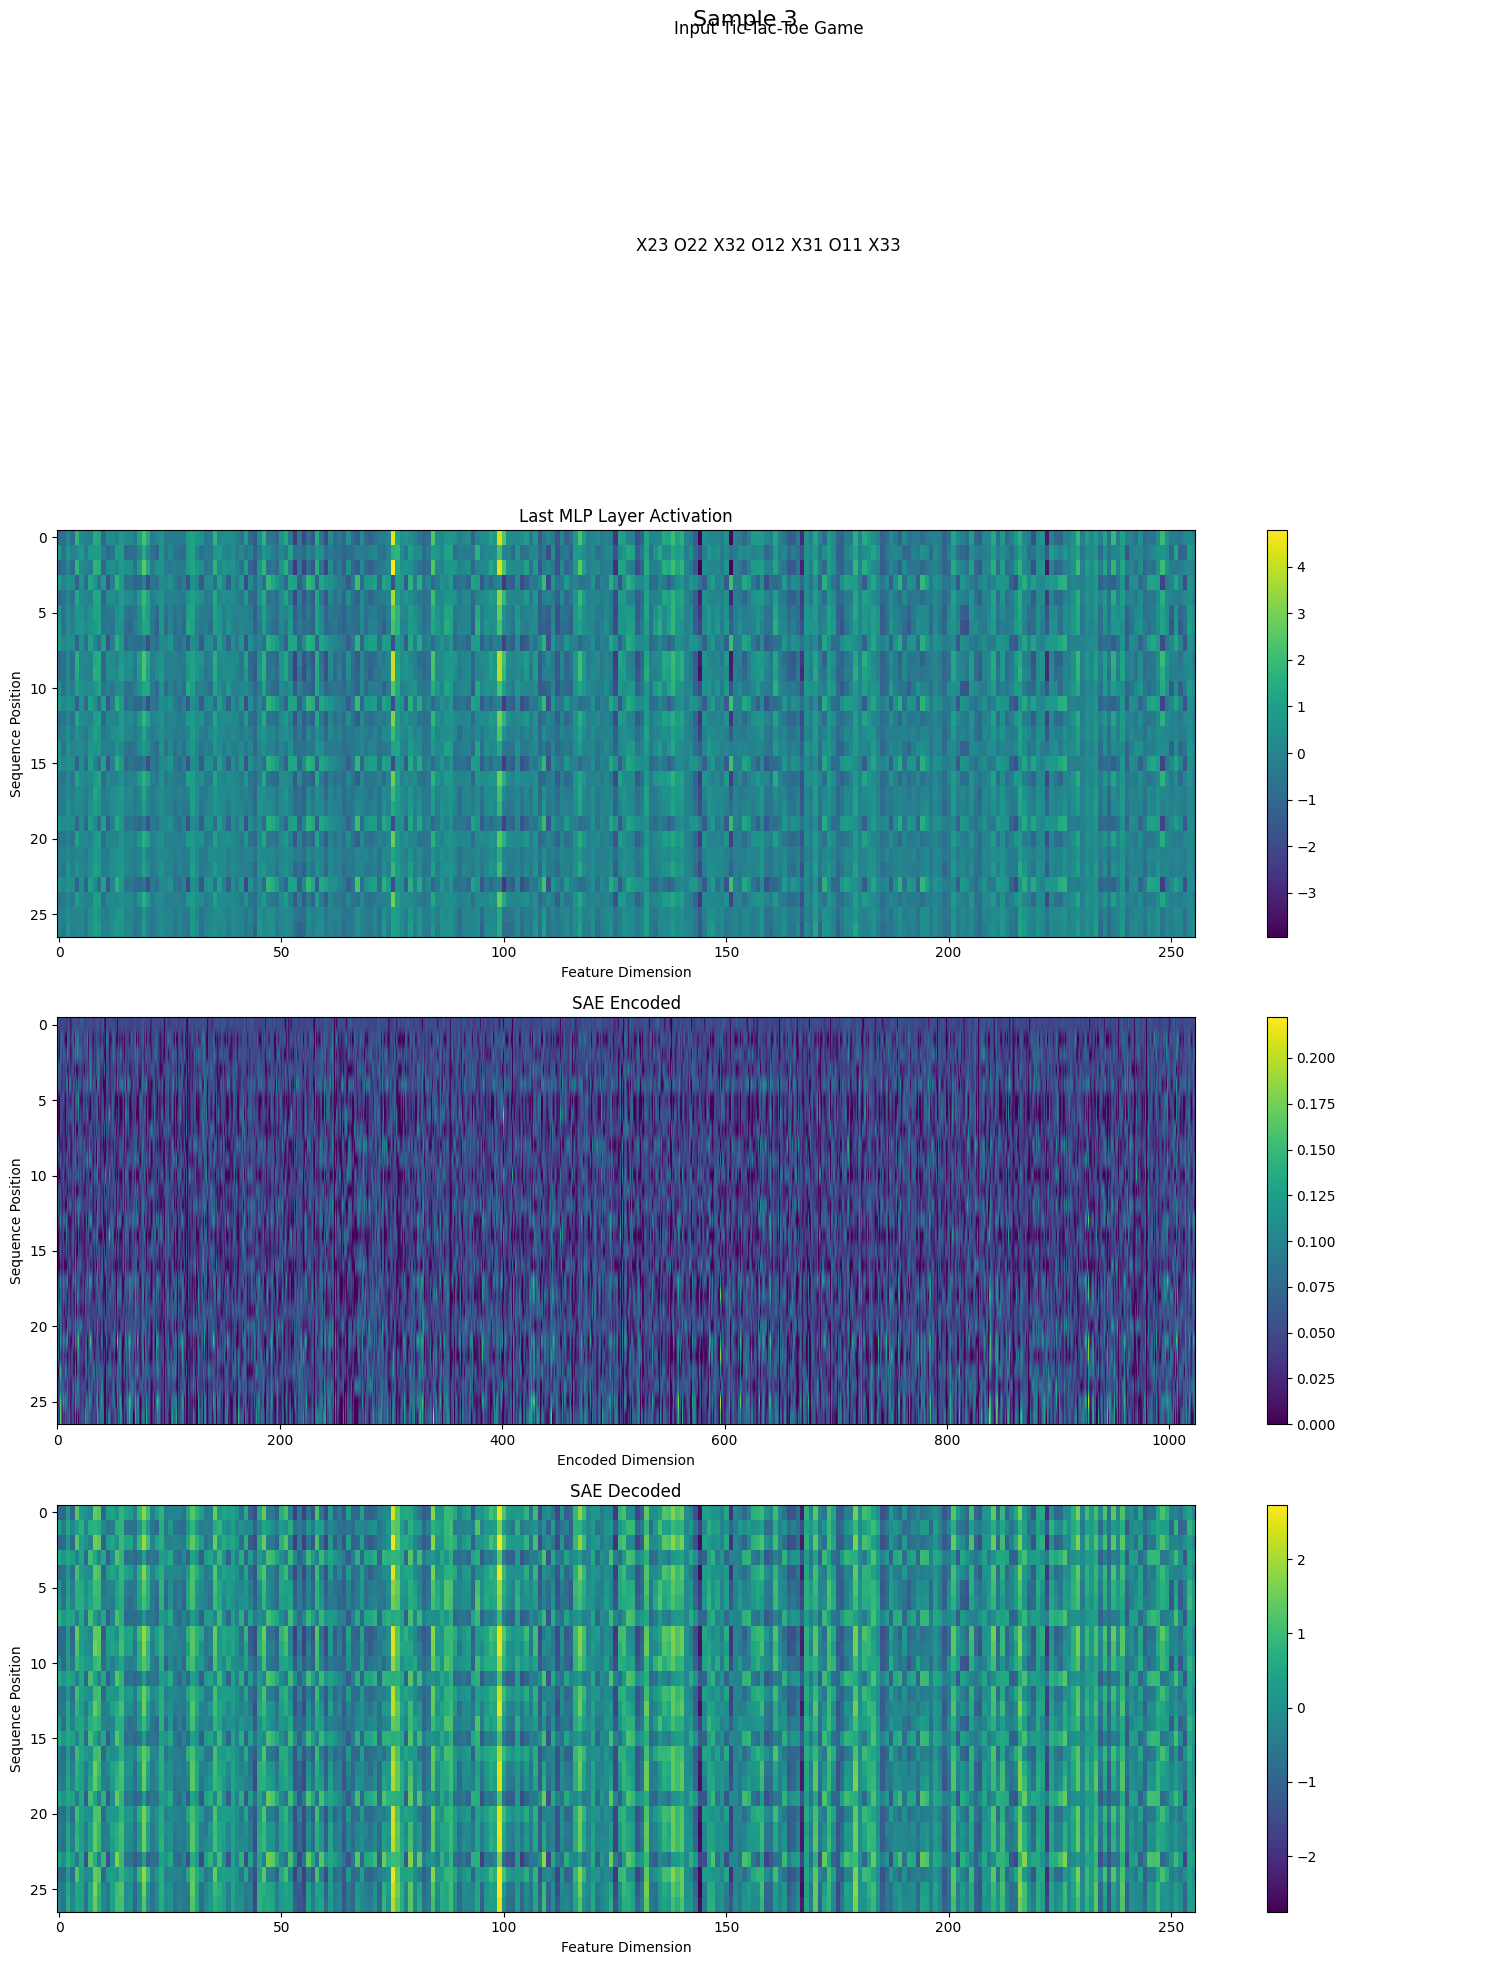

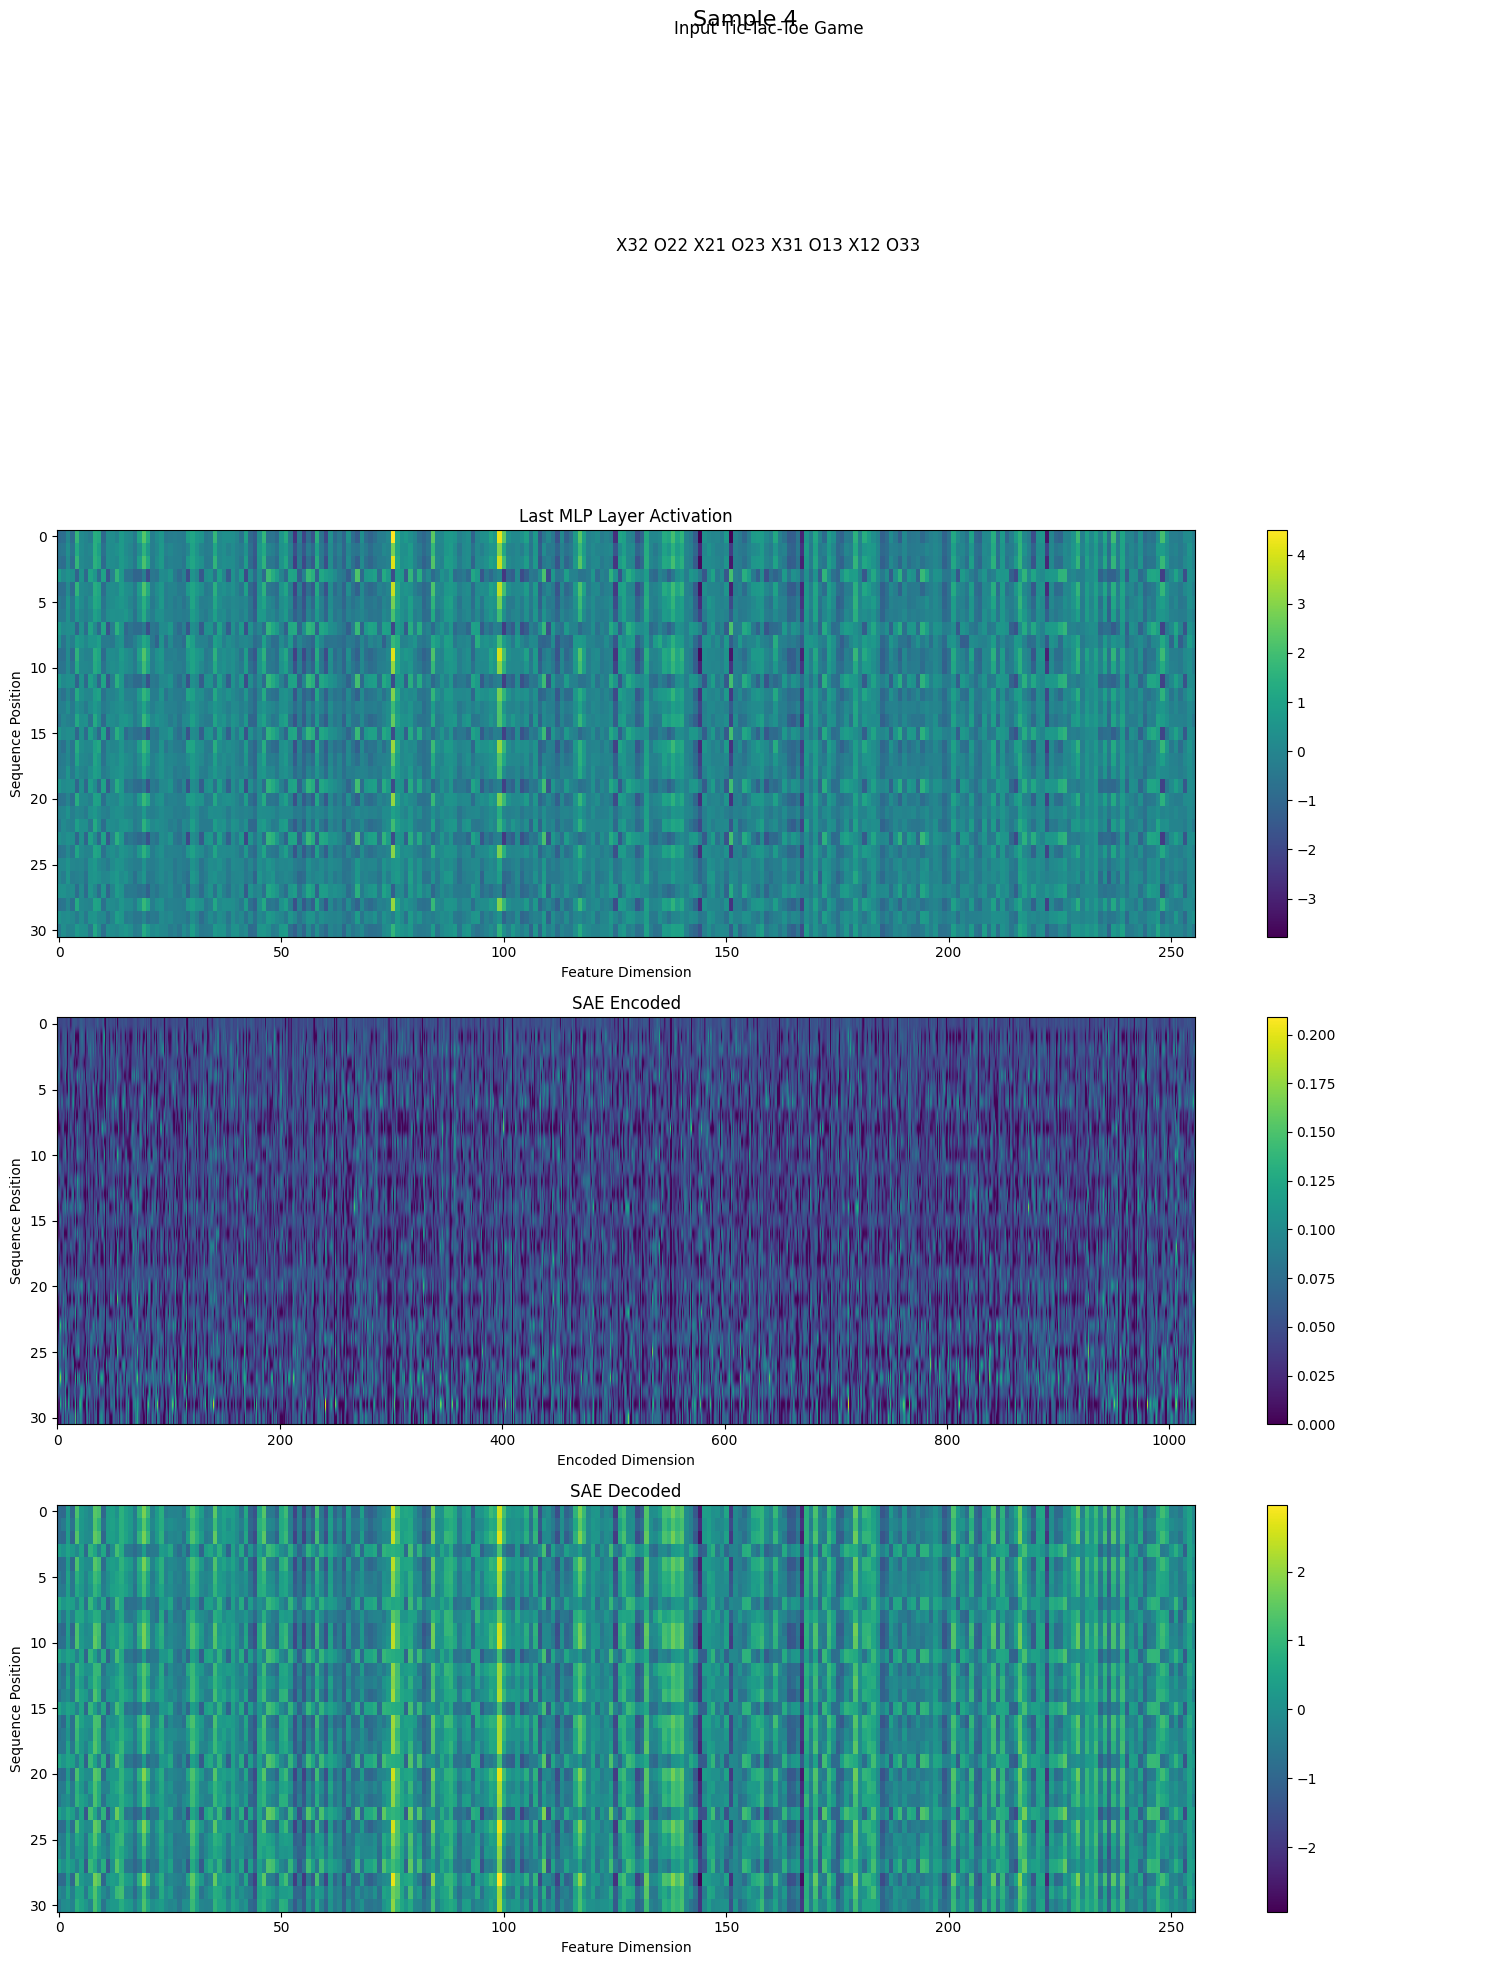

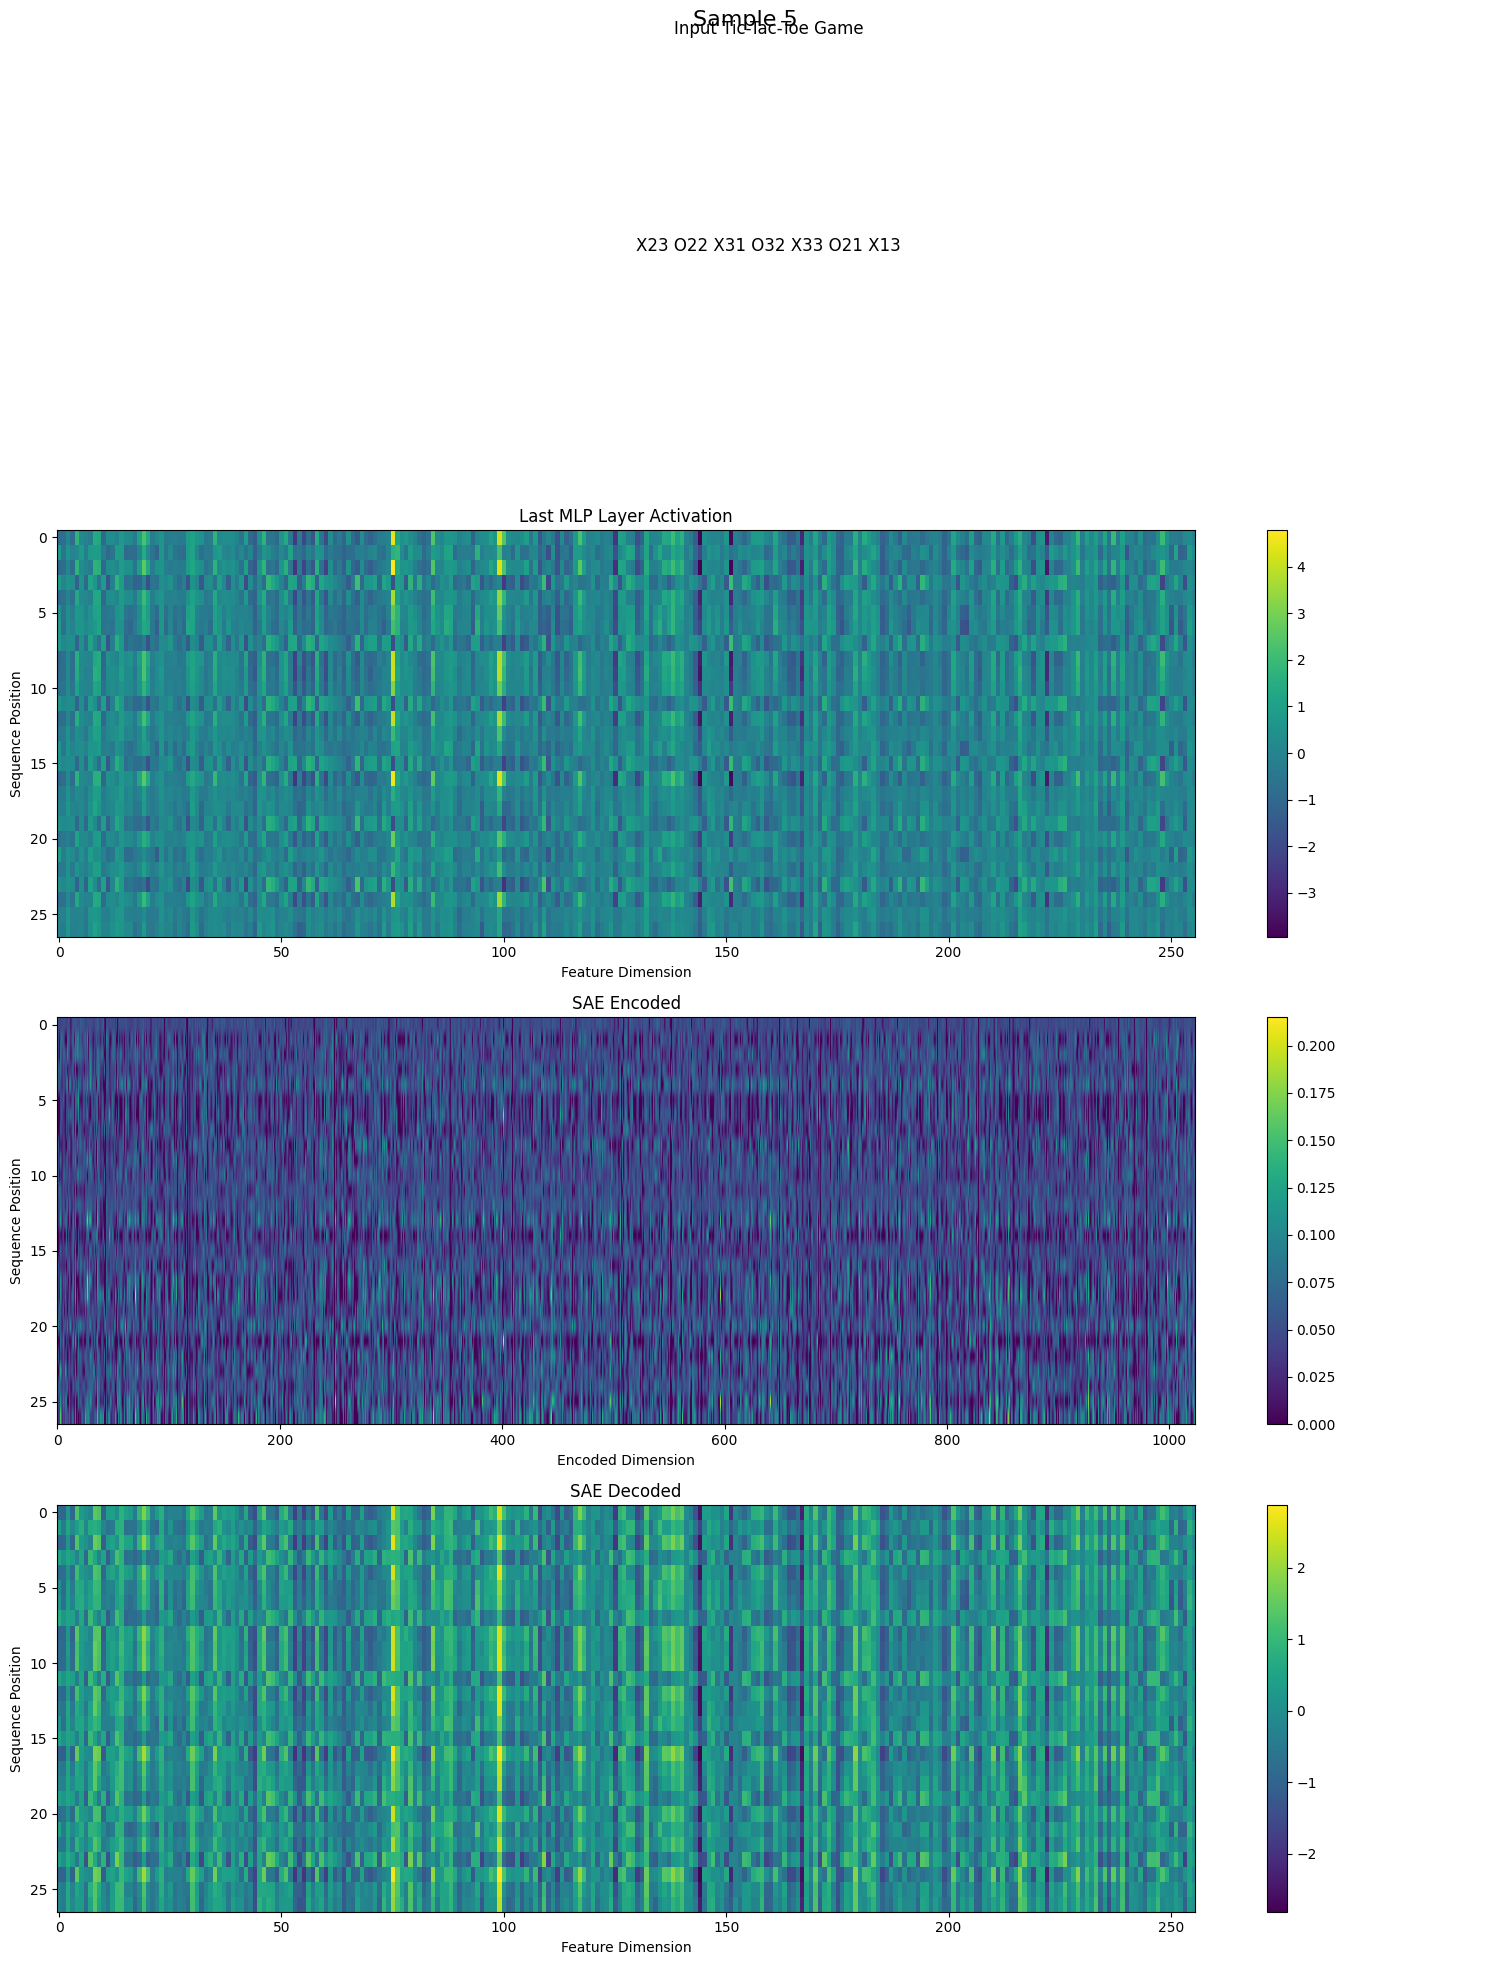

In [28]:
import torch
import matplotlib.pyplot as plt

# Définir le dispositif
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

def visualize_data_flow(gpt_model, sae_model, all_activations, random_games, stoi, itos, num_samples=5):
    gpt_model.eval()
    sae_model.eval()
    
    # Déplacer les modèles sur le bon dispositif
    gpt_model = gpt_model.to(device)
    sae_model = sae_model.to(device)
    
    # Fonction pour extraire les activations
    activations = []
    def hook_fn(module, input, output):
        activations.append(output.detach())
    
    # Ajouter le hook à la dernière couche MLP
    last_mlp = gpt_model.transformer.h[-1].mlp
    hook = last_mlp.register_forward_hook(hook_fn)
    
    for i in range(num_samples):
        # Sélectionner un jeu aléatoire
        game = random_games[i]
        encoded_game = encode_game(game)
        
        # Étape 1: Texte d'entrée décodé
        input_text = ' '.join(game)
        
        # Étape 2: Activation de la dernière couche MLP du GPT
        input_ids = torch.tensor(encoded_game, dtype=torch.long, device=device).unsqueeze(0)
        with torch.no_grad():
            gpt_model(input_ids)
            last_mlp_activation = activations[-1]
        activations.clear()
        
        # Étape 3: Encodage et décodage par le SAE
        with torch.no_grad():
            sae_encoded, sae_decoded = sae_model(last_mlp_activation)
        
        # Visualisation
        fig, axes = plt.subplots(4, 1, figsize=(15, 20))
        fig.suptitle(f"Sample {i+1}", fontsize=16)
        
        # Texte d'entrée
        axes[0].text(0.5, 0.5, input_text, fontsize=12, ha='center', va='center')
        axes[0].set_title("Input Tic-Tac-Toe Game")
        axes[0].axis('off')
        
        # Activation MLP
        im1 = axes[1].imshow(last_mlp_activation.squeeze().cpu(), aspect='auto', cmap='viridis')
        axes[1].set_title("Last MLP Layer Activation")
        axes[1].set_xlabel("Feature Dimension")
        axes[1].set_ylabel("Sequence Position")
        plt.colorbar(im1, ax=axes[1])
        
        # Encodage SAE
        im2 = axes[2].imshow(sae_encoded.squeeze().cpu(), aspect='auto', cmap='viridis')
        axes[2].set_title("SAE Encoded")
        axes[2].set_xlabel("Encoded Dimension")
        axes[2].set_ylabel("Sequence Position")
        plt.colorbar(im2, ax=axes[2])
        
        # Décodage SAE
        im3 = axes[3].imshow(sae_decoded.squeeze().cpu(), aspect='auto', cmap='viridis')
        axes[3].set_title("SAE Decoded")
        axes[3].set_xlabel("Feature Dimension")
        axes[3].set_ylabel("Sequence Position")
        plt.colorbar(im3, ax=axes[3])
        
        plt.tight_layout()
        plt.show()
    
    # Retirer le hook
    hook.remove()

# Fonctions utilitaires
def encode(s):
    return [stoi[c] for c in s if c in stoi]

def encode_game(game):
    return encode(' '.join(move for move in game))

# Assurez-vous que toutes les données sont sur le bon dispositif
all_activations = all_activations.to(device)

# Utilisation de la fonction
visualize_data_flow(model, sae, all_activations, random_games, stoi, itos, num_samples=5)